### Analysis of the correlation between Stock Markets and Elections

Project by Raphael Meiri, Or-Chanan Bruchim and Bernhard K. Sicking

The following data analysis has the goal to check if there is a signifikant correlation between election dates and stock markets in Europe. It is part of the course "Data Processing in Python" of the Charles University Prague. The results are presented as Jupyter Notebook files using Python 3.12.0. Detailed requirements can be found in the requirements file.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

The Analysis is build on two main data sets. The first one is an Excel file including election dates and outcomes of the five biggest economies in Europe: Germany, United Kingdom, France, Italy and Spain. The data looks at the most important election in each country (e.g. general elections in UK) and goes back to the 1980s. It includes the political position of the winning party and whether the election outcome was close or not.

In [2]:
# load election data from Excel File
# safe path of the Excel file needs to fit the path here
elec_data_file = r"C:\Users\berni\OneDrive\Dokumente\Python_Projects\Elections_Project\Election_Data_V3.xlsx" # please insert your path here
elec_data_unfiltered = pd.read_excel(elec_data_file, usecols="A:G")
elec_data_unfiltered['Date'] = pd.to_datetime(elec_data_unfiltered['Date'], errors='raise')

# filter elction data to only use last 25 years 
last_25_years = pd.to_datetime('today') - pd.DateOffset(years=25)
elec_data = elec_data_unfiltered[elec_data_unfiltered['Date'] > last_25_years].copy()

# give an index to the spectrum
spectrum_mapping = {"left": -2, "centre-left": -1, "centre": 0, "centre-right": 1, "right": 2}
elec_data["Spec_Index"] = elec_data["Spectrum"].map(spectrum_mapping)

# Adding indexes of the countries stocks
stock_mapping = {'UK':'^FTSE', 'Germany':'^GDAXI', 'Italy':'FTSEMIB.MI', 'France':'^FCHI', 'Spain':'^IBEX'}
elec_data['Index'] = elec_data['Country'].map(stock_mapping)

# Reorder the columns
elec_data = elec_data[['Date','Country','Index','Spectrum','Spec_Index','Close','Party','Share','Winner']]

# example of the first 10 entries
elec_data.head(10)

,Date,Country,Index,Spectrum,Spec_Index,Close,Party,Share,Winner
0,2021-09-26,Germany,^GDAXI,centre-left,-1,Yes,SPD,25.7,Scholz
1,2017-09-24,Germany,^GDAXI,centre,0,No,CDU,32.9,Merkel
2,2013-09-22,Germany,^GDAXI,centre,0,No,CDU,41.5,Merkel
3,2009-09-27,Germany,^GDAXI,centre-right,1,No,CDU,33.8,Merkel
4,2005-09-18,Germany,^GDAXI,centre,0,No,CDU,35.2,Merkel
5,2002-09-22,Germany,^GDAXI,centre-left,-1,Yes,SPD,38.5,Schroeder
12,2019-12-12,UK,^FTSE,centre-right,1,No,Tories,43.6,Johnson
13,2017-06-08,UK,^FTSE,centre-right,1,No,Tories,42.3,May
14,2015-05-07,UK,^FTSE,centre-right,1,Yes,Tories,36.8,Cameron
15,2010-05-06,UK,^FTSE,centre-right,1,Yes,Tories,36.1,Cameron


The second data set is from Yahoo Finance. It includes the stock market prices of the biggest indices from each of the five economies (e.g. DAX in Germany). The data has daily opening and closing numbers.

In [3]:
# clarification of what data to use from Yahoo Finance
tickers = ['^FTSE','^GDAXI','FTSEMIB.MI','^FCHI','^IBEX']
index_to_country = {'^FTSE':'UK','^GDAXI':'Germany','FTSEMIB.MI':'Italy','^FCHI':'France','^IBEX': 'Spain'}
start_date = '1999-01-01'
end_date = '2023-12-31'

# makes a new df by iterating through all five stock indices and adds country as a key
df = []
for index in tickers:
    data = yf.download(index, start=start_date, end=end_date)
    data['Index'] = index
    df.append(data)
stock_data_i = pd.concat(df)
stock_data_i['Country'] = stock_data_i['Index'].map(index_to_country)

# make date a key instead of index and set it to datetime 
stock_data = stock_data_i.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Reorder the columns
stock_data = stock_data[['Date', 'Country', 'Index', 'Open', 'Close', 'Adj Close', 'High', 'Low', 'Volume']]

# example of the first 10 entries
stock_data.head(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Country,Index,Open,Close,Adj Close,High,Low,Volume
0,1999-01-04,UK,^FTSE,5909.399902,5879.399902,5879.399902,5916.899902,5811.299805,689690000
1,1999-01-05,UK,^FTSE,5882.299805,5958.200195,5958.200195,5980.500000,5875.799805,1033599000
2,1999-01-06,UK,^FTSE,5968.899902,6148.799805,6148.799805,6157.399902,5968.899902,903848000
3,1999-01-07,UK,^FTSE,6145.899902,6101.200195,6101.200195,6153.700195,6042.500000,650124000
4,1999-01-08,UK,^FTSE,6115.399902,6147.200195,6147.200195,6195.600098,6114.799805,559612000
5,1999-01-11,UK,^FTSE,6164.600098,6085.000000,6085.000000,6186.500000,6063.299805,410137000
6,1999-01-12,UK,^FTSE,6086.100098,6033.600098,6033.600098,6140.299805,6024.500000,565013000
7,1999-01-13,UK,^FTSE,5984.200195,5850.100098,5850.100098,5984.200195,5746.500000,619930000
8,1999-01-14,UK,^FTSE,5842.000000,5820.200195,5820.200195,5937.799805,5798.700195,714333000
9,1999-01-15,UK,^FTSE,5804.600098,5941.000000,5941.000000,5941.000000,5736.799805,584966000


### Visulisation of the Data

To get a feeling for the general political spectrum in each country over the last 25 years, here is a visulisation of the results, showing how often the winning/leading parties were "left", "centre-left", "centre", "centre-right" or "right" on the political spectrum for each country. As you can see, all leading parties were either "centre-left", "centre" or "centre-right", except the current right wing leader in Italy. 

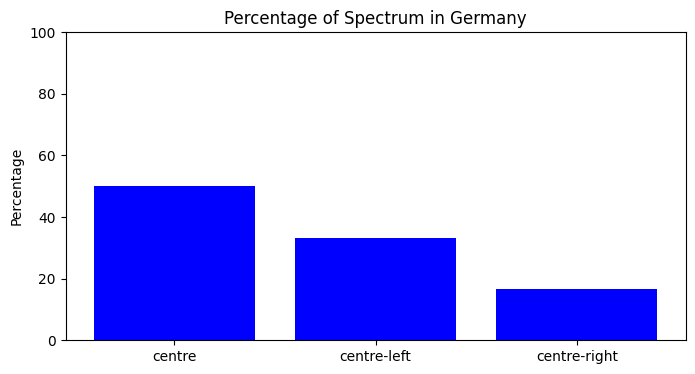

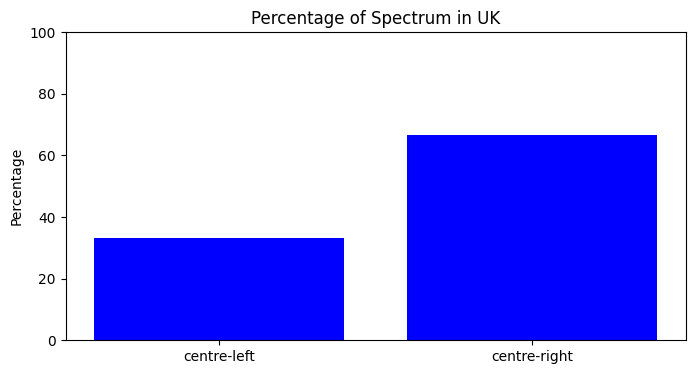

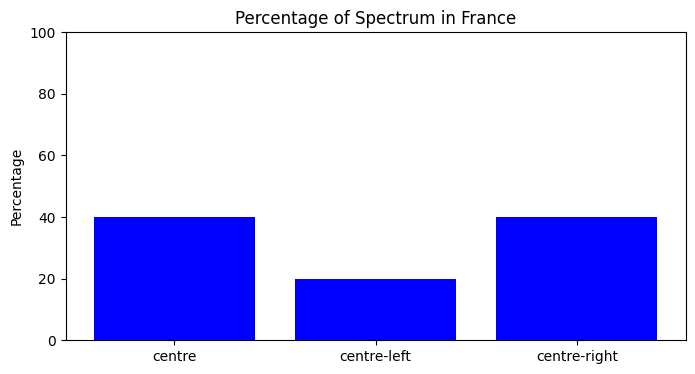

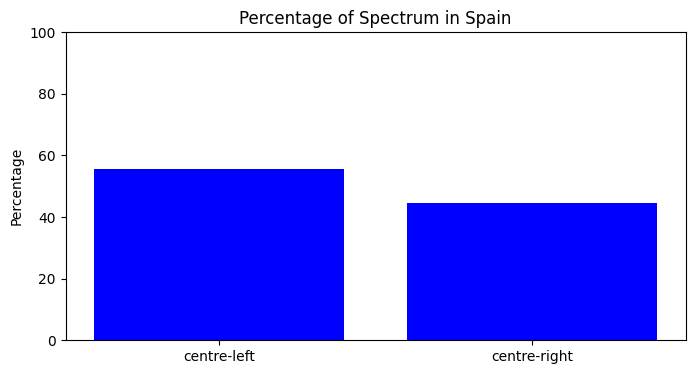

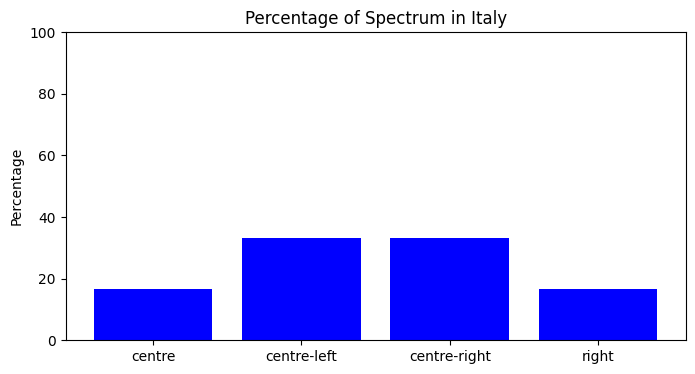

In [4]:
# Calculate the percentage of "left", "centre-left", "centre", "centre-right" and "right" for each country
country_counts = elec_data.groupby(['Country', 'Spectrum']).size()
country_totals = elec_data.groupby('Country').size()
percentages = (country_counts / country_totals) * 100

# Plot bar charts of the election spectrum for each country
for country in elec_data['Country'].unique():
    country_data = percentages.loc[country]
    plt.figure(figsize=(8, 4))
    plt.bar(country_data.index, country_data, color=['blue'])
    plt.ylabel('Percentage')
    plt.title(f'Percentage of Spectrum in {country}')
    plt.ylim(0, 100)
    plt.show()

In the following pictures one can see the developement of the biggest stock indices of each country over the last 25 years. It is clear that they all suffered from the DotCom Bubble, the Global Financial Crisis and Corona Virus, but they healed differently well. The red lines show the dates of each major election in the respectiv county. In further analysis we want to see, if elections have an significant effect as well. 

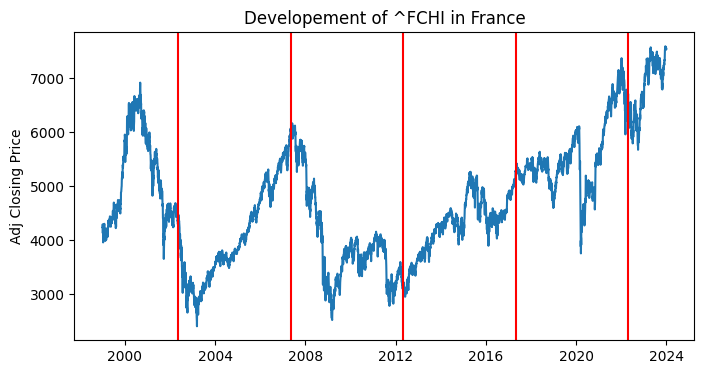

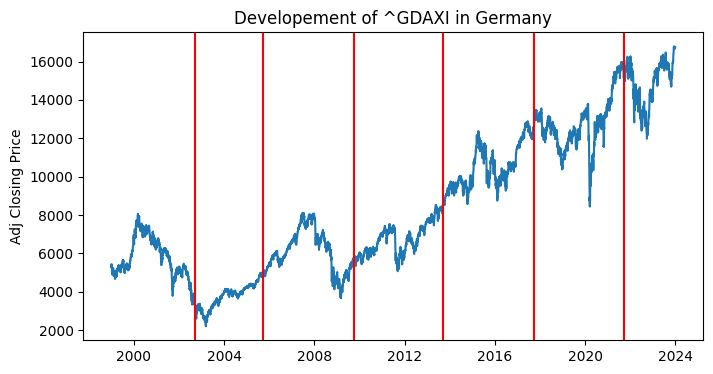

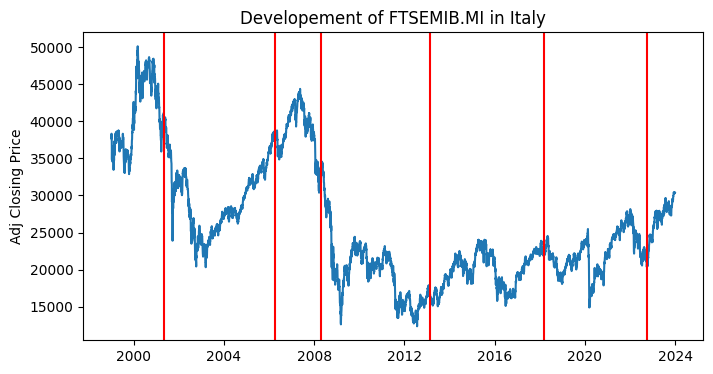

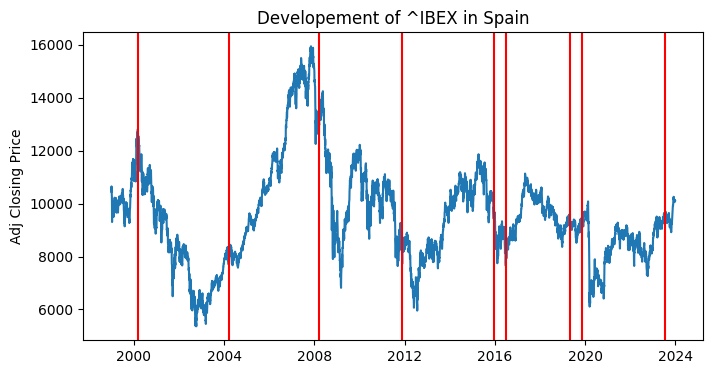

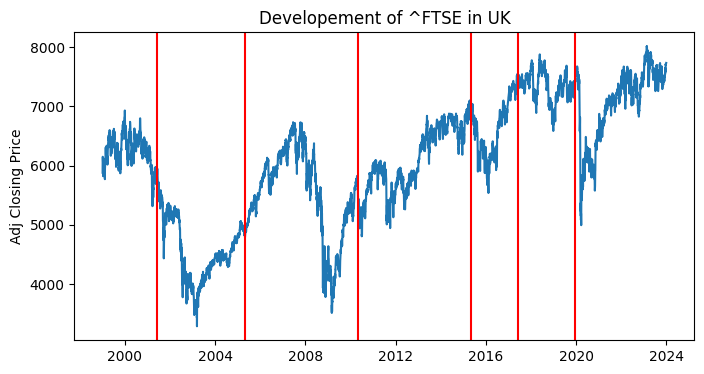

In [5]:
grouped_data = stock_data.groupby('Country')
specific_dates = elec_data.groupby('Country')['Date'].unique().apply(list).to_dict()
 
# plot line charts of the stock markets for each country
for country, country_data in grouped_data:
    plt.figure(figsize=(8, 4))
    plt.plot(country_data['Date'], country_data['Adj Close'])
    # add vertical line for the elections in each country
    if country in specific_dates:
        for date in specific_dates[country]:
            plt.axvline(x=pd.to_datetime(date), color='red') 
    plt.ylabel('Adj Closing Price')
    plt.title(f'Developement of {country_data['Index'].iloc[0]} in {country}')
    plt.show()

After this introduction, we present our main results in the Project_Main file.